# Classificação de músicas do Spotify 🎵

Esse trabalho tem como objetivo classificar uma base de dados de músicas do Spotify: "Spotify Tracks Dataset" do Kaggle utilizando um modelo preditivo para classificar músicas lentas e agitadas.

Essa base de dados é um conjunto de faixas de músicas do Spotify com uma variedade de 125 gêneros diferentes. Cada faixa possui alguns recursos de áudio associados a ela. 

O link desta base e mais detalhes se encontra em:
https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

# Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn.preprocessing   import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Base de Dados

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
df.shape

(114000, 21)

# Criando a variável target

## Problema de negócio

Classificar uma base de dados de músicas do Spotify em músicas lentas ou agitadas

## Descrição

De acordo com a regra de negócio, a coluna valence é uma medida de **0,0 a 1,0 que descreve a positividade musical transmitida por uma faixa**. Faixas com **alta valência soam mais positivas** (por exemplo, feliz, alegre, eufórica), enquanto faixas com **baixa valência** soam mais negativas (por exemplo, triste, deprimida, irritada).
Para criar a nossa coluna alvo do modelo preditivo, vamos utizar a coluna "valence" para ser nosso critério de músicas agitadas ou lentas.

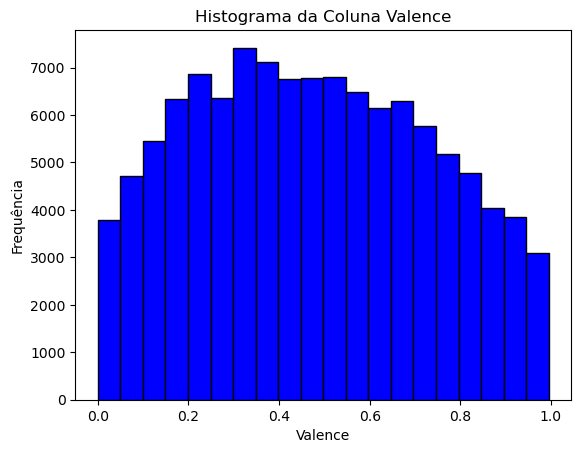

In [4]:
# Analisando a coluna "valence" para criar a nossa target
plt.hist(df['valence'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Valence')
plt.ylabel('Frequência')
plt.title('Histograma da Coluna Valence')
plt.show()

In [5]:
df['valence'].describe()

count    114000.000000
mean          0.474068
std           0.259261
min           0.000000
25%           0.260000
50%           0.464000
75%           0.683000
max           0.995000
Name: valence, dtype: float64

In [6]:
def categorizar_valence(row):
    if row['valence'] > 0.5:
        return 'agitada'
    else:
        return 'lenta'

# Crie a nova coluna 'target' usando a função categorizar_valence
df['target'] = df.apply(categorizar_valence, axis=1)
df.sample(6)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,agitada
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,lenta
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,lenta
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,lenta
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,lenta


# Feature Engineering

Como próximo passo, vamos armazenar em um novo dataframe apenas as colunas necessárias para nossa classificação de músicas.

In [8]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'target'],
      dtype='object')

In [9]:
df_musica = df.drop(['Unnamed: 0', 'track_id'], axis=1)
df_musica.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,agitada
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,lenta
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,lenta
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,lenta
4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,lenta


## Tratando os dados categóricos

LabelEncoder: Essa classe é utilizada para codificar rótulos de classes em números inteiros. É frequentemente usado quando se trabalha com algoritmos de aprendizado supervisionado que requerem rótulos numéricos.

In [10]:
def label_encoder_dataframe(df, columns_to_encode):
    le = LabelEncoder()

    for column in columns_to_encode:
        if column in df.columns:
            df[column] = le.fit_transform(df[column])
        else:
            print('A lista possui colunas que não existem no DataFrame.')

    return df

colunas_a_codificar = ['artists', 'album_name', 'track_name', 'explicit', 'track_genre', 'target']
label_encoder_dataframe(df_musica, colunas_a_codificar)
df_musica.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,10357,8100,11741,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,0
1,3287,14796,22528,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,1
2,12397,39162,60774,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,1
3,14839,8580,9580,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,5255,16899,25689,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


## Analisando as variáveis que vão compor nosso modelo 

<Axes: >

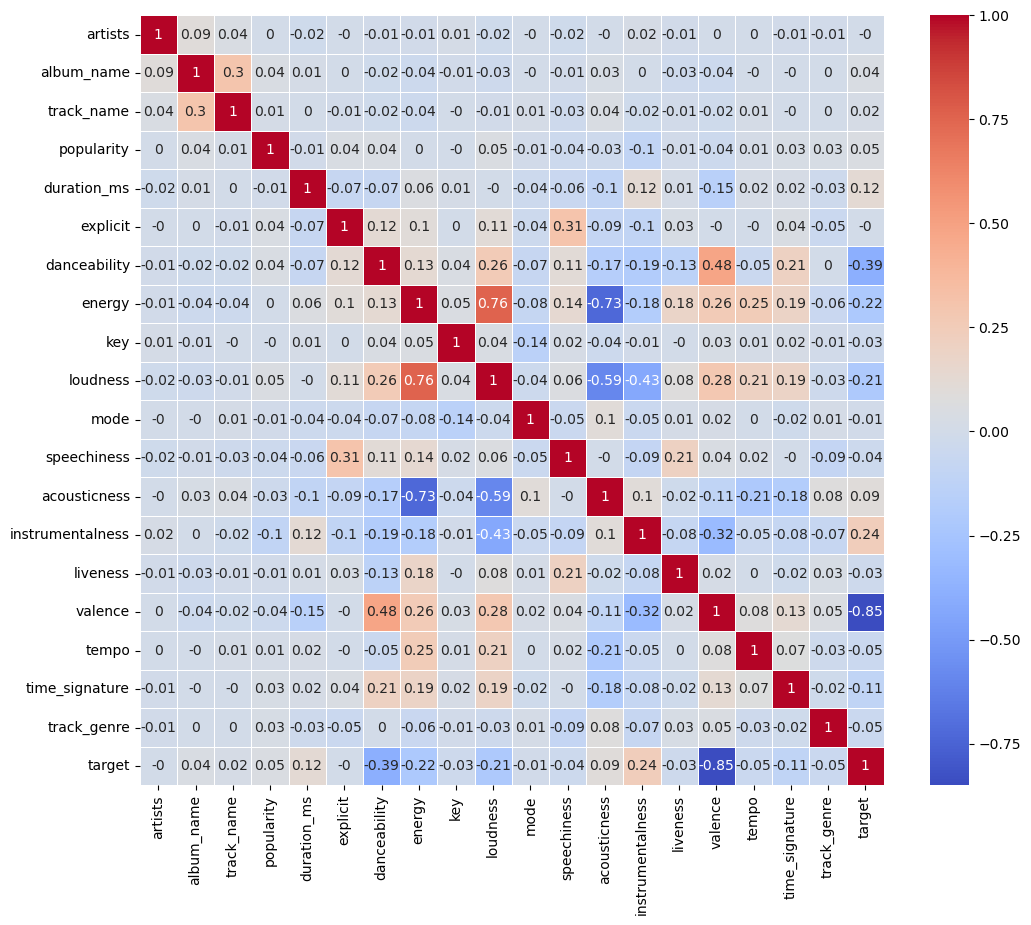

In [11]:
correlation_matrix = df_musica.corr().round(2)

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")

## Entendendo o equilíbrio da target

In [12]:
# Verificando o equilíbrio das classes
round(df_musica['target'].value_counts(normalize = True)*100,2)

target
1    54.37
0    45.63
Name: proportion, dtype: float64

In [13]:
set(df['target'])

{'agitada', 'lenta'}

In [14]:
set(df_musica['target'])

{0, 1}

# Machine Learning Model

## Separando os dados em treino e teste

In [15]:
df_musica.columns

Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'target'],
      dtype='object')

In [16]:
# separando os dados em treino e teste (método hold out)

#X = df_musica.drop('target', axis=1)
X = df_musica[['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'track_genre']]
y = df_musica['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [17]:
print(X_train.shape, X_test.shape)

(91200, 9) (22800, 9)


## Normalizando os dados

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Criar uma instância do MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train) # aqui falar sobre data leak

X_train_escalonado = scaler.transform(X_train)
X_test_escalonado = scaler.transform(X_test)


 ## Função para executar modelos de machine learning
 
 Vamos criar uma função que vai executar o modelo preditivo e avaliar a sua performance utilizando as principais métricas de validação.

In [19]:
def roda_modelo(modelo):

    from sklearn.metrics import roc_curve, roc_auc_score, classification_report

    # Treinando modelo com os dados de treino
    modelo.fit(X_train_escalonado, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(X_test_escalonado) # obter as probabilidades associadas às classes previstas para cada instância de dados
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(X_test_escalonado)
    print("\nClassification Report")
    print(classification_report(y_test, predicao))

    print("\nRoc Curve\n")
    # Fazer previsões de probabilidades
    y_pred_probs = modelo.predict_proba(X_test_escalonado)[:, 1]

    # Calcular a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

    # Calcular a AUC (área sob a curva ROC)
    auc = roc_auc_score(y_test, y_pred_probs)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})') # linewidth
    plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Converter probabilidades em classes preditas (0 ou 1)
    y_pred = (y_pred_probs > 0.5).astype(int)

## Regressão logística
O modelo se baseia em uma **função logística**, que transforma as variáveis independentes em uma probabilidade entre 0 e 1.  Para novas entradas de dados, o modelo calcula a **probabilidade do evento binário ocorrer**.

AUC 0.7962059470391694

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     10403
           1       0.74      0.75      0.75     12397

    accuracy                           0.72     22800
   macro avg       0.72      0.72      0.72     22800
weighted avg       0.72      0.72      0.72     22800


Roc Curve



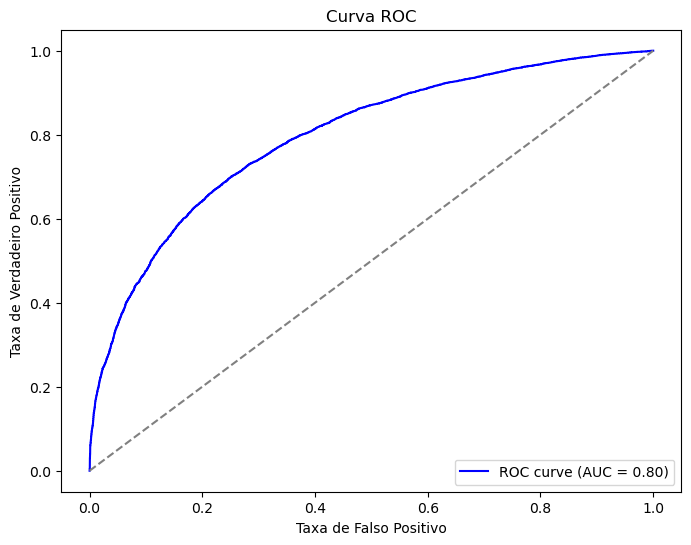

In [20]:
modelo_logistico = LogisticRegression()
roda_modelo(modelo_logistico)

## KNN (K-Nearest Neighbors)
Para um novo ponto de dados, o KNN identifica os **K pontos mais próximos (vizinhos)** no conjunto de treinamento. A classe do novo ponto é a classe mais frequente entre os K vizinhos.

AUC 0.8117874424738845

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     10403
           1       0.77      0.78      0.78     12397

    accuracy                           0.75     22800
   macro avg       0.75      0.75      0.75     22800
weighted avg       0.75      0.75      0.75     22800


Roc Curve



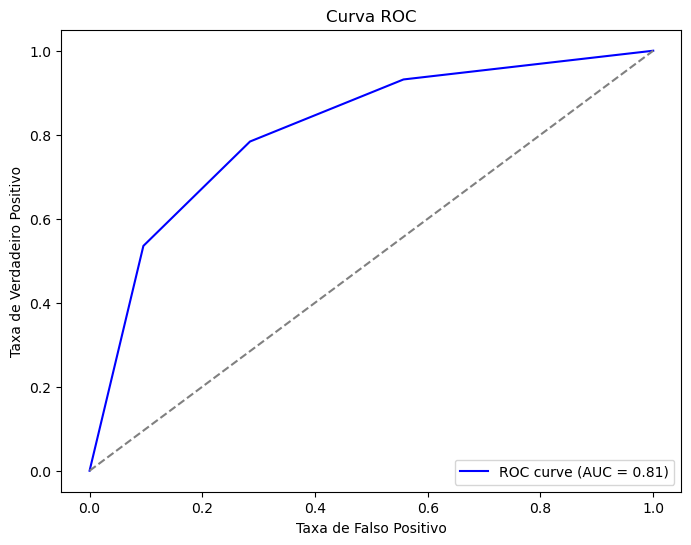

In [21]:
modelo_knn = KNeighborsClassifier(n_neighbors=3)
roda_modelo(modelo_knn)

## Random Florest
O Random Forest Classifier é um algoritmo de **ensemble learning**, que **combina vários modelos para melhorar a performance**. O modelo cria uma floresta de árvores de decisão, onde cada árvore é treinada em um subconjunto aleatório dos dados (bootstrap). A classe final do novo ponto de dados é a classe mais votada pelas árvores da floresta.

AUC 0.8299975921559042

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     10403
           1       0.76      0.78      0.77     12397

    accuracy                           0.75     22800
   macro avg       0.75      0.74      0.74     22800
weighted avg       0.75      0.75      0.75     22800


Roc Curve



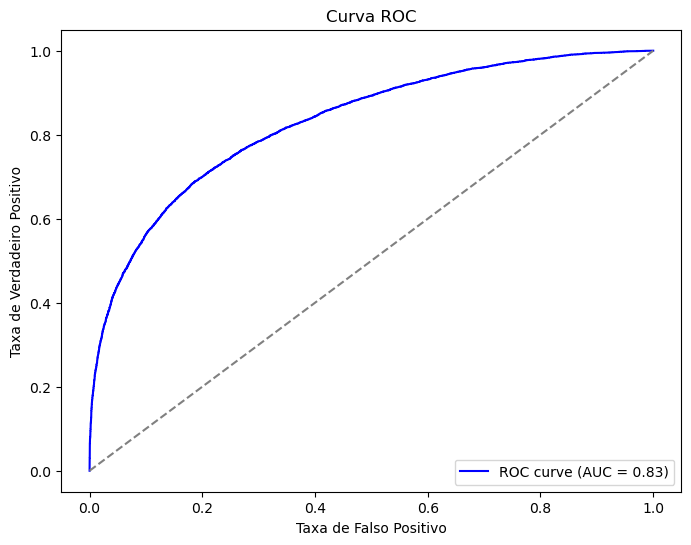

In [22]:
modelo_random_forest = RandomForestClassifier(max_depth=7, n_estimators= 100)
roda_modelo(modelo_random_forest)

## Testando novos parâmetros com Grid Search

In [23]:
# Defina os parâmetros a serem testados
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15]
}

# GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', n_jobs=1)

# Ajuste o modelo ao conjunto de dados
grid_search.fit(X_train_escalonado, y_train)

rf_params = grid_search.best_params_
print("Melhores hiperparâmetros:", rf_params)



Melhores hiperparâmetros: {'max_depth': 15, 'n_estimators': 200}


AUC 0.9052657533566351

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     10403
           1       0.84      0.84      0.84     12397

    accuracy                           0.82     22800
   macro avg       0.82      0.82      0.82     22800
weighted avg       0.82      0.82      0.82     22800


Roc Curve



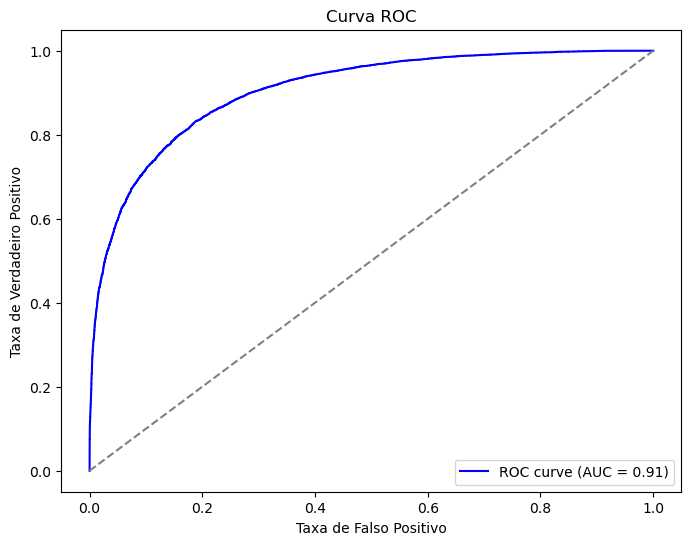

In [26]:
modelo_random_forest_gs = RandomForestClassifier(max_depth=15, n_estimators= 200)
roda_modelo(modelo_random_forest_gs)

# Testando o modelo para novos dados

In [25]:
novos_dados = pd.read_excel("novos_dados.xlsx")
base_original = pd.read_excel("novos_dados.xlsx")

#Criando a pipeline
coluna = ['track_genre']
label_encoder_dataframe(novos_dados, coluna)
novos_dados = scaler.transform(novos_dados)

# Realize a previsão usando o modelo Random Forest treinado
previsoes = modelo_random_forest_gs.predict(novos_dados)

# Obtendo o predict
def mapear_valor(valores):
    resultados = []
    for valor in valores:
        if valor == 0:
            resultados.append('Música agitada')
        elif valor == 1:
            resultados.append('Música lenta')
        else:
            resultados.append('Desconhecido')
    return np.array(resultados)

base_original['target'] = mapear_valor(previsoes)
base_original.head()

,popularity,duration_ms,danceability,energy,loudness,acousticness,instrumentalness,liveness,track_genre,target
0,80,200000,0.89,0.8,-19333,0.0555,0.976,0.45,rock,Música agitada
1,30,205000,0.20,0.5,-11773,0.0100,0.452,0.20,folk,Música lenta
